SVM Linear Kernal 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(50)

# Importing the dataset
dataset = pd.read_csv('C:\\Users\\isarachchand\\Documents\\git\\apf\\datasets\\aml\\data\\PS_20174392719_1491204439457_log.csv')
column_names = dataset.columns


dataset.drop('nameOrig', axis=1, inplace=True)
dataset.drop('nameDest', axis=1, inplace=True)
dataset.drop('isFlaggedFraud', axis=1, inplace=True)

In [2]:
column_names = list(column_names)
column_names.append('predictions')

column_names


['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'predictions']

In [3]:
sample_dataframe = dataset.sample(n=100000)
X = sample_dataframe.iloc[:, :-1].values
y = sample_dataframe.iloc[:, 7].values

print(sample_dataframe.isFraud.value_counts())

print(X)

0    99872
1      128
Name: isFraud, dtype: int64
[[235 'TRANSFER' 386193.12 ... 0.0 2325434.5 2711627.62]
 [18 'TRANSFER' 340641.56 ... 0.0 45779.12 386420.68]
 [405 'CASH_OUT' 28362.68 ... 0.0 458073.56 486436.24]
 ...
 [227 'PAYMENT' 36390.28 ... 13120.72 0.0 0.0]
 [277 'CASH_OUT' 111857.53 ... 0.0 2253356.7 2365214.22]
 [303 'CASH_OUT' 142962.49 ... 0.0 1107885.91 1250848.4]]


In [4]:
# # Encoding categorical data
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# labelencoder = LabelEncoder()

# X[:, 1] = labelencoder.fit_transform(X[:, 1])

# onehotencoder = OneHotEncoder(categorical_features = [1])

# X = onehotencoder.fit_transform(X).toarray()

# # Avoiding the Dummy Variable Trap
# X = X[:, 1:]


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(columnTransformer.fit_transform(X),dtype=np.str)




C:\Users\ISARAC~1\AppData\Local\Temp/ipykernel_9940/2811974595.py:20: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array(columnTransformer.fit_transform(X),dtype=np.str)


In [5]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

counts = np.unique(y_train, return_counts=True)


In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
print(counts)

(array([0, 1], dtype=int64), array([69918,    82], dtype=int64))


In [7]:
# Fitting Kernel SVM to the Training set
import sys


from sklearn.svm import LinearSVC
from imblearn.under_sampling import NearMiss
from imblearn import over_sampling as os
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [8]:
# Apply the sampling
ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X_train, y_train)
count = np.unique(y_resampled, return_counts=True)

# Create a pipeline

pipeline4 = make_pipeline(ADASYN(),LinearSVC(random_state=1))
pipeline4.fit(X_train, y_train)
print(count)

predicted_results = pipeline4.predict(X_test)

(array([0, 1], dtype=int64), array([69918, 69918], dtype=int64))


C:\Users\isarachchand\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [9]:
# Classify and report the results
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, pipeline4.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.96      0.99      0.97      0.94     14973
          1       0.06      0.96      0.97      0.11      0.97      0.93        27

avg / total       1.00      0.97      0.96      0.98      0.97      0.94     15000



In [10]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, precision_score,auc,roc_auc_score,roc_curve,recall_score
cm = confusion_matrix(y_val, pipeline4.predict(X_val))
roc = roc_auc_score(y_val, pipeline4.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, pipeline4.predict(X_val))
roc_auc = auc(fpr,tpr)

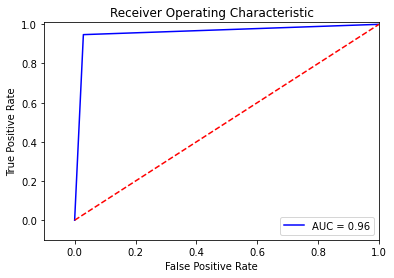

In [11]:
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Linear Kernel SVM = AUC 0.96

In [12]:
# Output to CSV file

print(X_test.shape)

print(predicted_results.shape)


output_data = np.append(X_test, predicted_results[:, None], axis=1)

# X_test['isFraud'] = predicted_results


df_fraud_classify = pd.DataFrame(output_data)
df_fraud_classify.columns = column_names

file_name = r'C:\Users\isarachchand\Documents\git\apf\output\aml\aml_data_output.csv'
df_fraud_classify.to_csv(file_name, encoding='utf-8', index=False)



(15000, 11)
(15000,)


In [13]:
#df_fraud_classify.head()

dataset.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [14]:
isFraud = dataset['isFraud']

isFraud

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int64